In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
vvar3 = yf.Ticker("VVAR3.SA")
vvar_hist = vvar3.history(period='max')['Close']

Date
2017-01-03   -0.021885
2017-01-04    0.018249
2017-01-05    0.002158
2017-01-06   -0.011129
2017-01-09   -0.003167
Name: VVAR3, dtype: float64


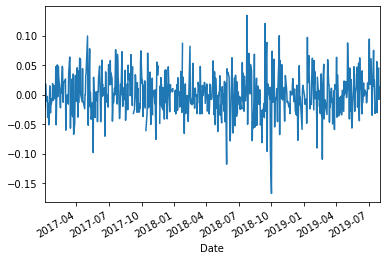

In [3]:
vvar_hist = vvar_hist['2017-01-01':'2019-08-01'].apply(np.log).diff().dropna()
risk_free = pd.read_excel("http://www.nefin.com.br/Risk%20Factors/Risk_Free.xls")
risk_free['Date'] = pd.to_datetime(risk_free['year'].astype(str) + "-" + risk_free['month'].astype(str) + "-" + risk_free['day'].astype(str), format="%Y-%m-%d")
risk_free.set_index('Date',inplace=True)
risk_free= risk_free['2017-01-01':]
risk_free.drop(["year",'month','day'],axis=1,inplace=True)
vvar_hist = pd.DataFrame(vvar_hist).join(risk_free,on="Date",how='outer')
vvar_hist["Close"] = vvar_hist["Close"] - vvar_hist["Risk_free"]
vvar_hist = vvar_hist["Close"]
vvar_hist.rename("VVAR3",inplace=True)
print(vvar_hist.head())
%matplotlib inline
vvar_hist.plot()

            year  month  day  Rm_minus_Rf
Date                                     
2017-01-02  2017      1    2    -0.009658
2017-01-03  2017      1    3     0.033867
2017-01-04  2017      1    4    -0.002037
2017-01-05  2017      1    5     0.006557
2017-01-06  2017      1    6    -0.006024


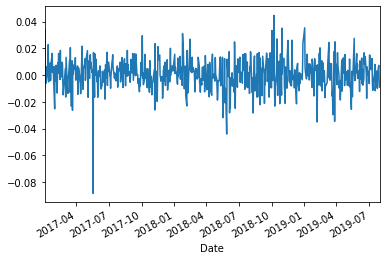

In [4]:
market_factor = pd.read_excel("http://www.nefin.com.br/Risk%20Factors/Market_Factor.xls")
market_factor['Date'] = pd.to_datetime(market_factor['year'].astype(str) + "-" + market_factor['month'].astype(str) + "-" + market_factor['day'].astype(str), format="%Y-%m-%d")
market_factor.set_index('Date',inplace=True)
market_factor= market_factor['2017-01-01':]
print(market_factor.head())
market_factor['Rm_minus_Rf'].plot()

In [5]:
reg_df = pd.DataFrame(vvar_hist).join(market_factor,on="Date",how='outer').dropna()
reg_df.head()

,VVAR3,year,month,day,Rm_minus_Rf
Date,,,,,
2017-01-03,-0.021885,2017.0,1.0,3.0,0.033867
2017-01-04,0.018249,2017.0,1.0,4.0,-0.002037
2017-01-05,0.002158,2017.0,1.0,5.0,0.006557
2017-01-06,-0.011129,2017.0,1.0,6.0,-0.006024
2017-01-09,-0.003167,2017.0,1.0,9.0,-0.000015


CAPM: $R = \alpha + \beta R_{M}$

In [6]:
import statsmodels.api as sm
model = sm.OLS(reg_df['VVAR3'],sm.add_constant(reg_df['Rm_minus_Rf']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  VVAR3   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     91.58
Date:                Thu, 08 Aug 2019   Prob (F-statistic):           2.37e-20
Time:                        14:04:51   Log-Likelihood:                 1269.7
No. Observations:                 634   AIC:                            -2535.
Df Residuals:                     632   BIC:                            -2527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.153      

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
smb_factor = pd.read_excel("http://www.nefin.com.br/Risk%20Factors/SMB_Factor.xls")
smb_factor['Date'] = pd.to_datetime(smb_factor['year'].astype(str) + "-" + smb_factor['month'].astype(str) + "-" + smb_factor['day'].astype(str), format="%Y-%m-%d")
smb_factor.set_index('Date',inplace=True)
smb_factor= smb_factor['2017-01-01':]

hml_factor = pd.read_excel("http://www.nefin.com.br/Risk%20Factors/HML_Factor.xls")
hml_factor['Date'] = pd.to_datetime(hml_factor['year'].astype(str) + "-" + hml_factor['month'].astype(str) + "-" + hml_factor['day'].astype(str), format="%Y-%m-%d")
hml_factor.set_index('Date',inplace=True)
hml_factor= hml_factor['2017-01-01':]

In [8]:
market_factor.drop(["year",'month','day'],axis=1,inplace=True)
smb_factor.drop(["year",'month','day'],axis=1,inplace=True)
hml_factor.drop(["year",'month','day'],axis=1,inplace=True)

ff_df = pd.DataFrame(vvar_hist).join(market_factor,on="Date",how='outer').join(smb_factor,on="Date",how='outer').join(hml_factor,on="Date",how='outer').dropna()
ff_df.head()

,VVAR3,Rm_minus_Rf,SMB,HML
Date,,,,
2017-01-03,-0.021885,0.033867,-0.004176,0.004721
2017-01-04,0.018249,-0.002037,0.021841,0.007483
2017-01-05,0.002158,0.006557,0.010802,0.021504
2017-01-06,-0.011129,-0.006024,0.001409,0.008247
2017-01-09,-0.003167,-0.000015,0.000429,-0.001637


Fama French 3 factor: $R = \alpha + \beta_1 R_m + \beta_2 SMB + \beta_3 HML$

In [9]:
ff_model = sm.OLS(ff_df['VVAR3'],sm.add_constant(ff_df[['Rm_minus_Rf','SMB',"HML"]]))
ff_results = ff_model.fit()
print(ff_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  VVAR3   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     33.01
Date:                Thu, 08 Aug 2019   Prob (F-statistic):           7.92e-20
Time:                        14:04:55   Log-Likelihood:                 1273.1
No. Observations:                 634   AIC:                            -2538.
Df Residuals:                     630   BIC:                            -2520.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.001      0.133      